<a href="https://colab.research.google.com/github/mohsenfayyaz/NLP_Assignments/blob/master/Week1_Predict_tags_on_StackOverflow_with_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week1() 
    
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

--2020-07-14 15:23:41--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2020-07-14 15:23:41 (29.2 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


In [154]:
from grader import Grader
grader = Grader()

In [155]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [157]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [324]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [325]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [326]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

**Task 1 (TextPrepare)**

In [327]:
import re

In [328]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def multiple_replace(old_list, string):
    string_split = string.split(" ")
    for old in old_list:
        while old in string_split:
            string_split.remove(old)
    string = ' '.join(string_split)
    return string

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str.lower(text)  # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)  # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text)  # delete symbols which are in BAD_SYMBOLS_RE from text
    text = multiple_replace(STOPWORDS, text)  # delete stopwords from text
    text = ' '.join(text.split())  ### delete multiple spaces
    return text


In [329]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            print(text_prepare(ex))
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [330]:
print(test_text_prepare())

Basic tests are passed.


In [331]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [332]:
X_train[10]

'Obtaining the object the java.lang.Class<T> object for a parameterized type without constructing the class in q_uestion?'

In [333]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [334]:
X_train[10]

'obtaining object javalangclasst object parameterized type without constructing class q_uestion'

In [335]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

**Task 2 (WordsTagsCount)**

In [336]:
# Dictionary of all tags from train corpus with their counts. (y)
tags_counts = {}
# Dictionary of all words from train corpus with their counts. (x)
words_counts = {}

######################################
######### YOUR CODE HERE #############
######################################

for title in X_train:
    for word in title.split(" "):
        words_counts[word] = words_counts.setdefault(word, 0) + 1

for tags in y_train:
    for tag in tags:
        tags_counts[tag] = tags_counts.setdefault(tag, 0) + 1


In [337]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


**Transforming text to a vector**

***Bag of words***

In [338]:
DICT_SIZE = 5000

all_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
all_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {mcw[0]: i for i, mcw in enumerate(all_most_common_words)}  ####### YOUR CODE HERE #######
INDEX_TO_WORDS = {i: mcw[0] for i, mcw in enumerate(all_most_common_words)}  ####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word, index  in words_to_index.items():
        if word in text:
            result_vector[index] = 1
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    return result_vector

In [339]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [340]:
print(test_my_bag_of_words())

Basic tests are passed.


In [341]:
from scipy import sparse as sp_sparse

In [343]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


**Task 3 (BagOfWords)**

In [344]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = len(row.nonzero()[0])  ####### YOUR CODE HERE #######
grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 44...


**TF-IDF**

In [345]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [346]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')  ####### YOUR CODE HERE #######

    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [347]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [348]:
######### YOUR CODE HERE #############
print("c++" in tfidf_vocab.keys() and "c#" in tfidf_vocab.keys())

True


**MultiLabel classifier**

In [349]:
from sklearn.preprocessing import MultiLabelBinarizer

In [350]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [351]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [352]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    clf = OneVsRestClassifier(LogisticRegression(max_iter=500, penalty="l2", C=1.0)).fit(X_train, y_train)  # C: smaller values specify stronger regularization.
    return clf

In [353]:
classifier_mybag = train_classifier(X_train_mybag, y_train)

In [354]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [355]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [356]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [357]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


* accuracy
* F1-score macro/micro/weighted
* Precision macro/micro/weighted


In [358]:
def print_evaluation_scores(y_val, predicted):
    print(accuracy_score(y_val, predicted))
    print(f1_score(y_val, predicted, average="macro"))
    print(f1_score(y_val, predicted, average="micro"))
    print("F1-w:", f1_score(y_val, predicted, average="weighted"))
    print(average_precision_score(y_val, predicted, average="macro"))
    print(average_precision_score(y_val, predicted, average="micro"))
    print(average_precision_score(y_val, predicted, average="weighted"))
    ######################################
    ######### YOUR CODE HERE #############
    ######################################


In [359]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3686333333333333
0.522067312080979
0.6857160221218321
F1-w: 0.662835936927019
0.3565037168759405
0.49514605365399317
0.5238243030946215
Tfidf
0.33393333333333336
0.44547849037643034
0.6417403871419813
F1-w: 0.6142668931088263
0.30181976655232984
0.4569269920283416
0.4850317686052679


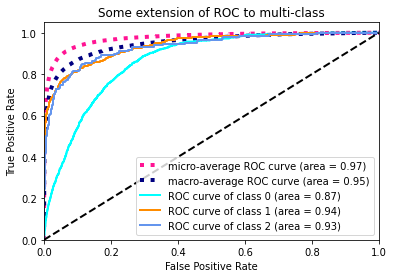

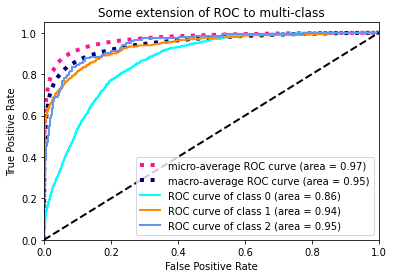

In [360]:
from metrics import roc_auc
%matplotlib inline
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).**

In [361]:
######################################  changes did not improve F1
######### YOUR CODE HERE #############
######################################

In [362]:
test_predictions = classifier_mybag.predict(X_test_mybag)  ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,eclipse,java
5	php,xml
6	ajax,javascript,j...


**Analysis of the most important features**

In [251]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    logisitic_regression = classifier.estimator
    logisitic_regression.

    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = # top-5 words sorted by the coefficiens.
    top_negative_words = # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

SyntaxError: ignored

In [252]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

NameError: ignored

In [256]:
classifier_mybag.estimator.coef_

AttributeError: ignored

**Authorization & Submission**

In [257]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 54...
Task MultilabelClassification:
 0	php
1	javascript,jquery
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java
8	python
9	h...


In [365]:
STUDENT_EMAIL = "mohsen.fayyaz77@gmail.com"  # EMAIL 
STUDENT_TOKEN = "nNthWtgHjHFKYu3D"  # TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 44...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,eclipse,java
5	php,xml
6	ajax,javascript,j...


In [366]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
